# Fraud detection combining both Amazon Fraud Detector and Amazon SageMaker models in the same transaction

Importing tools and libraries to be used

In [89]:
import os
import io
import sys
import json
import uuid
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import boto3
import time
import sklearn
import seaborn as sns
import sagemaker

from IPython.display import clear_output
from datetime import datetime
from io import StringIO
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score, classification_report
%matplotlib inline
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from math import sqrt

## Investigate and process the data

Let's start by downloading and reading the ULB credit card fraud data set.

In [2]:
%%bash
wget https://fraud-detector-blog-assets.s3.amazonaws.com/creditcard.csv

--2020-09-22 19:57:02--  https://fraud-detector-blog-assets.s3.amazonaws.com/creditcard.csv
Resolving fraud-detector-blog-assets.s3.amazonaws.com (fraud-detector-blog-assets.s3.amazonaws.com)... 52.217.14.180
Connecting to fraud-detector-blog-assets.s3.amazonaws.com (fraud-detector-blog-assets.s3.amazonaws.com)|52.217.14.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150828752 (144M) [text/csv]
Saving to: ‘creditcard.csv.1’

     0K .......... .......... .......... .......... ..........  0%  629K 3m54s
    50K .......... .......... .......... .......... ..........  0%  630K 3m54s
   100K .......... .......... .......... .......... ..........  0%  635K 3m53s
   150K .......... .......... .......... .......... ..........  0% 84.5M 2m55s
   200K .......... .......... .......... .......... ..........  0% 82.6M 2m20s
   250K .......... .......... .......... .......... ..........  0%  643K 2m35s
   300K .......... .......... .......... .......... ..........  0%

In [66]:
# Resources and env variables setup
s3_resource = boto3.resource('s3')
afd_resource = boto3.client('frauddetector')

# suffix is appended to detector and model name for uniqueness  
sufx = datetime.now().strftime("%Y%m%d")
# prefix is prepended to the sagamaker components
prefx = 'sagemaker-model'
# replace with the training bucket created in the CloudFormation
S3_BUCKET = "afd-poc-trainingbucket-1i37svk9elcoe"
# replace with the output bucket created in the CloudFormation
S3_OUT_BUCKET = "afd-poc-outputbucket-1fhn20d7tumgg"
# Replace the ARN Role with the resources created in CloudFormation stack
ARN_ROLE = "arn:aws:iam::387461613214:role/afd-poc-NotebookInstanceExecutionRole-1FNQ41S8H2G68" 

In [45]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data = pd.read_csv('creditcard.csv', delimiter=',')

Let's take a peek at our data (we only show a subset of the columns in the table):

In [5]:
print(data.columns)
data.describe()

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'], dtype='object')


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
nonfrauds, frauds = data.groupby('Class').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds:  492
Number of non-frauds:  284315
Percentage of fradulent data: 0.1727485630620034


The class column corresponds to whether or not a transaction is fradulent. We see that the majority of data is non-fraudulent with only $492$ ($.173\%$), check the Class column mean, of the data corresponding to fraudulent examples.

A PCA have been made lets check the mean and standard deviation of the features.

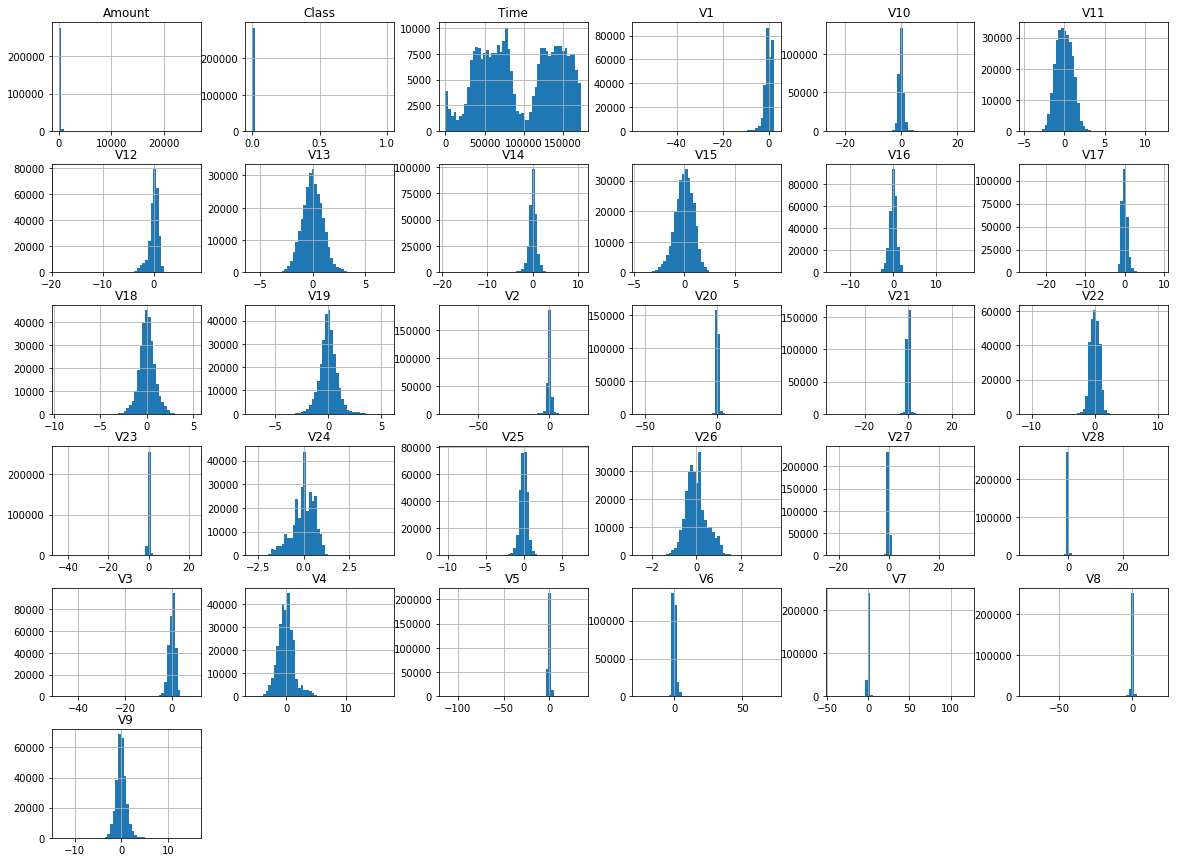

In [7]:
data.hist(bins=50,figsize=(20,15))
plt.show()

Looks good, columns 𝑉𝑖 have been normalized to have 0 mean and unit standard deviation as the result of a PCA. Now, lets change the data to be Amazon Fraud Detector compatible.

In [50]:
# to lowercase
data.columns = map(str.lower, data.columns)
print(data.columns)

Index(['time', 'va', 'vb', 'vc', 'vd', 've', 'vf', 'vg', 'vh', 'vi', 'vj', 'vk', 'vl', 'vm', 'vn', 'vo', 'vp', 'vq', 'vr', 'vs', 'vt', 'vu', 'vv', 'vw', 'vx', 'vy', 'vz', 'vaa', 'vab', 'amount', 'class'], dtype='object')


In [46]:
# mapping column names numbers to letters

def standardize_headers(x):
    if any(char.isdigit() for char in x):
        if int(x[1:]) > 26:
            return 'va'+chr(int(x[1:])+70)
        return 'v'+chr(int(x[1:])+96)
    return x

data.rename(columns=standardize_headers, inplace=True)
print(data.columns)

Index(['Time', 'va', 'vb', 'vc', 'vd', 've', 'vf', 'vg', 'vh', 'vi', 'vj', 'vk', 'vl', 'vm', 'vn', 'vo', 'vp', 'vq', 'vr', 'vs', 'vt', 'vu', 'vv', 'vw', 'vx', 'vy', 'vz', 'vaa', 'vab', 'Amount', 'Class'], dtype='object')


Then change the timestamp and label column names

In [51]:
# rename to the Amazon Fraud Detector name conventions 
data.rename(columns={'class':'EVENT_LABEL'}, inplace=True)
data.head()

,time,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount,EVENT_LABEL
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Get epoch time for the initial dataset date

In [34]:
# Get epoch time for the initial dataset date
epoch = datetime.utcfromtimestamp(0)
def unix_time_seconds(dt):
    return (dt - epoch).total_seconds()

# Lets pretend that the data is from yesterday and could can test at the end with todays date.
start_dt = datetime.strptime('Sep 22 2020  12:00AM', '%b %d %Y %I:%M%p')
start_dt = datetime.now()
start_ep = unix_time_seconds(start_dt)
print(start_ep)

1600808118.409983


The date column is represented as incremental seconds, lets translate it to dates formats.

In [35]:
# translate seconds delta to actual datetimes in ISO 8601
def to_datetime(x):
    current_ep = start_ep + x
    current_dt = time.strftime('%Y-%m-%dT%H:%M:%SZ', time.localtime(current_ep))
    return current_dt


data['EVENT_TIMESTAMP'] = data['time'].apply(to_datetime)
data.head()

,time,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount,EVENT_LABEL,EVENT_TIMESTAMP
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,2020-09-22T20:55:18Z
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,2020-09-22T20:55:18Z
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,2020-09-22T20:55:19Z
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,2020-09-22T20:55:19Z
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,2020-09-22T20:55:20Z


We will split our dataset into a train and test to evaluate the performance of our models. It's important to do so before any techniques meant to alleviate the class imbalance are used. This ensures that we don't leak information from the test set into the train set.

In [52]:
features = data.drop('EVENT_LABEL', axis=1).values
labels = (data['EVENT_LABEL'].values).astype('float32')

In [53]:
X, X_test, y, y_test = train_test_split(
    features, labels, test_size=0.1, random_state=42)

In [54]:
counter = Counter(y)
print(counter)

Counter({0.0: 255880, 1.0: 446})


Getting the training and testing DataFrame back together

In [55]:
saved_cols = data.drop('EVENT_LABEL', axis=1).columns
print(saved_cols)
data = pd.DataFrame(X, columns = saved_cols)
data['EVENT_LABEL']=y.astype(int)
data.head(10)

Index(['time', 'va', 'vb', 'vc', 'vd', 've', 'vf', 'vg', 'vh', 'vi', 'vj', 'vk', 'vl', 'vm', 'vn', 'vo', 'vp', 'vq', 'vr', 'vs', 'vt', 'vu', 'vv', 'vw', 'vx', 'vy', 'vz', 'vaa', 'vab', 'amount'], dtype='object')


,time,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount,EVENT_LABEL
0,28515.0,1.226643,0.101988,-0.087072,0.111524,-0.281992,-1.356027,0.469050,-0.371725,-0.153672,-0.145105,-0.143505,0.320964,0.149313,0.452515,0.776253,0.028739,-0.177867,-1.004746,0.264953,0.019692,-0.355100,-1.153663,0.109793,0.420318,0.197932,0.699218,-0.114861,0.007583,50.40,0
1,83125.0,1.124848,0.125602,0.249962,0.489744,-0.040386,0.167561,-0.247614,0.284736,-0.067302,-0.170139,1.895117,0.507733,-1.008648,0.187249,1.021663,0.136320,0.370186,-0.573559,-0.625413,-0.204465,-0.192467,-0.576819,0.190343,-0.357451,0.000870,0.139971,-0.000993,0.011505,1.98,0
2,75537.0,-0.307902,1.003715,1.404277,0.592627,0.311014,-0.382106,0.531393,-0.015292,-0.758638,-0.511597,0.149643,0.245866,0.752802,-0.382214,1.590185,-0.332546,0.611852,-0.510495,0.563779,0.125220,-0.131802,-0.329268,0.046990,0.057413,-0.656960,0.193192,0.142038,0.157501,1.98,0
3,156358.0,2.174919,-1.535441,-0.726428,-1.430792,-1.517258,-0.751038,-1.155344,-0.180811,-1.111885,1.536101,-0.735705,-0.771714,0.238603,-0.447050,-0.085886,-0.568345,0.591162,-0.104975,-0.327292,-0.334351,-0.112766,0.050018,0.294666,1.123322,-0.306025,-0.241343,0.006553,-0.027567,64.00,0
4,162523.0,-2.221556,1.261987,2.047642,4.659268,-0.535941,4.542044,-3.715525,-5.311701,-0.955321,0.200601,-1.342622,0.879905,0.241171,-0.365540,-1.735410,0.564495,0.380648,1.216692,1.872711,0.895990,-1.820388,0.873723,-2.648598,-0.162180,-0.492111,0.601490,0.627030,0.088289,379.29,0
5,113992.0,-0.335198,0.871378,0.632703,4.164242,1.702582,1.954354,0.396722,0.495056,-2.506020,1.609137,1.029249,-0.143569,-0.129187,0.862428,1.059507,-0.862144,0.597711,-0.509967,0.217672,0.260404,0.529635,1.473558,0.033413,-1.333266,-0.779961,0.595196,0.231547,0.193332,57.78,0
6,18653.0,-1.305978,1.772118,0.741730,0.912351,0.498898,1.737490,-0.957795,-1.692301,0.755233,-0.641461,0.900131,-0.935381,3.068228,1.564764,-1.357441,-0.216156,0.712878,0.354701,0.959930,-0.579386,1.985454,-1.290109,0.108807,-1.427937,0.140905,-0.393444,0.078297,-0.052505,1.00,0
7,133445.0,-0.303356,1.144996,-0.843639,-1.046609,0.945826,-1.822700,1.694510,-0.465604,-0.095435,-0.150239,-1.004530,-0.509581,-1.039596,0.805069,-0.077089,-0.649795,-0.363229,-0.307477,-0.163633,0.007469,0.208148,0.842970,-0.201490,0.076193,-0.277275,0.093339,0.497711,0.336480,17.00,0
8,87252.0,-0.465920,0.628365,1.449569,4.417351,1.034654,1.083905,0.103565,-0.624355,-0.226190,2.979203,-1.319708,-1.136836,-0.027942,-0.972251,0.758803,-0.104912,-0.462734,0.521972,1.049701,-0.055464,0.192156,1.231734,-0.113115,0.603061,-1.890037,0.069854,-0.907822,-0.133170,11.31,0
9,40607.0,0.271095,-2.720489,0.427427,-0.080256,-2.077311,0.334682,-0.620412,0.174167,0.087480,0.347286,0.319218,-0.528176,-1.560458,-0.281460,-1.103553,1.181354,0.433565,-0.623177,1.165483,1.068453,0.341998,-0.188797,-0.504412,0.027295,0.140939,-0.294037,-0.063847,0.102788,552.89,0


Get epoch time for the initial dataset date

In [56]:
# Get epoch time for the initial dataset date
epoch = datetime.utcfromtimestamp(0)
def unix_time_seconds(dt):
    return (dt - epoch).total_seconds()

# Lets pretend that the data is from yesterday and could can test at the end with todays date.
start_dt = datetime.strptime('Sep 22 2020  12:00AM', '%b %d %Y %I:%M%p')
start_dt = datetime.now()
start_ep = unix_time_seconds(start_dt)
print(start_ep)

1600808761.483827


The date column is represented as incremental seconds, lets translate it to dates formats.

In [57]:
# translate seconds delta to actual datetimes in ISO 8601
def to_datetime(x):
    current_ep = start_ep + x
    current_dt = time.strftime('%Y-%m-%dT%H:%M:%SZ', time.localtime(current_ep))
    return current_dt


data['EVENT_TIMESTAMP'] = data['time'].apply(to_datetime)
data.head()

,time,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount,EVENT_LABEL,EVENT_TIMESTAMP
0,28515.0,1.226643,0.101988,-0.087072,0.111524,-0.281992,-1.356027,0.469050,-0.371725,-0.153672,-0.145105,-0.143505,0.320964,0.149313,0.452515,0.776253,0.028739,-0.177867,-1.004746,0.264953,0.019692,-0.355100,-1.153663,0.109793,0.420318,0.197932,0.699218,-0.114861,0.007583,50.40,0,2020-09-23T05:01:16Z
1,83125.0,1.124848,0.125602,0.249962,0.489744,-0.040386,0.167561,-0.247614,0.284736,-0.067302,-0.170139,1.895117,0.507733,-1.008648,0.187249,1.021663,0.136320,0.370186,-0.573559,-0.625413,-0.204465,-0.192467,-0.576819,0.190343,-0.357451,0.000870,0.139971,-0.000993,0.011505,1.98,0,2020-09-23T20:11:26Z
2,75537.0,-0.307902,1.003715,1.404277,0.592627,0.311014,-0.382106,0.531393,-0.015292,-0.758638,-0.511597,0.149643,0.245866,0.752802,-0.382214,1.590185,-0.332546,0.611852,-0.510495,0.563779,0.125220,-0.131802,-0.329268,0.046990,0.057413,-0.656960,0.193192,0.142038,0.157501,1.98,0,2020-09-23T18:04:58Z
3,156358.0,2.174919,-1.535441,-0.726428,-1.430792,-1.517258,-0.751038,-1.155344,-0.180811,-1.111885,1.536101,-0.735705,-0.771714,0.238603,-0.447050,-0.085886,-0.568345,0.591162,-0.104975,-0.327292,-0.334351,-0.112766,0.050018,0.294666,1.123322,-0.306025,-0.241343,0.006553,-0.027567,64.00,0,2020-09-24T16:31:59Z
4,162523.0,-2.221556,1.261987,2.047642,4.659268,-0.535941,4.542044,-3.715525,-5.311701,-0.955321,0.200601,-1.342622,0.879905,0.241171,-0.365540,-1.735410,0.564495,0.380648,1.216692,1.872711,0.895990,-1.820388,0.873723,-2.648598,-0.162180,-0.492111,0.601490,0.627030,0.088289,379.29,0,2020-09-24T18:14:44Z


In [58]:
test = pd.DataFrame(X_test, columns = saved_cols)
test.head(10)

,time,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount
0,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,5.299236,-10.834006,1.671120,-9.373859,0.360806,-9.899247,-19.236292,-8.398552,3.101735,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19
1,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,-0.087670,0.979427,0.076883,-0.217884,-0.136830,-2.142892,0.126956,1.752662,0.432546,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12
2,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,0.543827,0.112453,1.075384,-0.245772,0.180483,1.769860,-0.533172,-0.533300,1.192245,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00
3,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,-1.328335,0.223621,1.132627,-0.550875,0.616568,0.497974,0.502195,0.981343,0.101264,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50
4,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,0.942162,0.850038,-0.616166,0.592634,-0.603845,0.091077,-0.471867,-0.333816,0.404711,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89
5,67878.0,-0.641330,-0.057304,1.489998,-1.688131,-1.151043,0.259996,-1.391069,-2.334075,1.168644,-2.084080,0.480381,0.473738,-2.192276,0.773942,0.294484,0.406074,-0.541855,1.031450,0.017076,0.618411,-1.231634,0.257164,-0.371953,-0.038566,1.397514,-0.665947,0.031003,0.180357,100.00
6,159763.0,2.023952,-0.120140,-1.086918,0.423019,-0.142901,-1.127752,0.178493,-0.303234,0.564509,0.062831,-0.720047,0.366835,-0.110857,0.319094,0.108359,-0.153633,-0.221312,-0.934141,0.070553,-0.210864,-0.276175,-0.697708,0.335631,-0.017196,-0.324904,0.200023,-0.071566,-0.058224,16.99
7,139631.0,-0.688944,1.292153,-0.564281,-1.457526,2.258333,-0.323270,1.678984,-0.104128,-1.285351,-1.303435,0.282728,-0.402525,-0.548687,-0.504283,-0.685339,0.714828,-0.092674,0.798953,-0.150085,-0.037150,-0.006880,-0.171568,-0.720019,-0.419435,1.211991,0.670916,-0.103986,0.030084,8.95
8,133944.0,2.119362,0.142639,-2.373337,0.541949,0.608419,-1.775564,0.955775,-0.599383,0.010420,0.295305,-0.936569,-0.452478,-1.340798,1.077459,-0.099584,-0.815072,0.018481,-0.639446,-0.065427,-0.323573,0.264264,0.898266,-0.168063,0.059311,0.626949,0.729035,-0.129120,-0.094713,10.00
9,58769.0,-5.584256,-4.732413,-0.448452,-0.121442,-0.707412,-0.114376,-1.554628,1.402126,-0.031693,-0.942358,-2.439501,-0.552312,-0.295588,-0.250246,-1.197732,1.549553,0.933237,-1.237689,0.416832,-1.046900,0.041651,0.621789,0.223467,-0.770137,0.621182,-0.028738,0.505194,-1.898323,101.49


In [59]:
# The testing dataset with the labels to perform evaluations latter on
test_label = pd.DataFrame(X_test, columns = saved_cols)
test_label['EVENT_LABEL']=y_test.astype(int)
test_label.head()

,time,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount,EVENT_LABEL
0,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,5.299236,-10.834006,1.671120,-9.373859,0.360806,-9.899247,-19.236292,-8.398552,3.101735,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
1,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,-0.087670,0.979427,0.076883,-0.217884,-0.136830,-2.142892,0.126956,1.752662,0.432546,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
2,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,0.543827,0.112453,1.075384,-0.245772,0.180483,1.769860,-0.533172,-0.533300,1.192245,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
3,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,-1.328335,0.223621,1.132627,-0.550875,0.616568,0.497974,0.502195,0.981343,0.101264,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
4,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,0.942162,0.850038,-0.616166,0.592634,-0.603845,0.091077,-0.471867,-0.333816,0.404711,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0


In [60]:
#validating the test dataset with labels
nonfrauds, frauds = test_label.groupby('EVENT_LABEL').size()
print('Number of frauds in test data: ', frauds)
print('Number of non-frauds in test data: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

Number of frauds in test data:  46
Number of non-frauds in test data:  28435
Percentage of fradulent data: 0.16151118289385907


Number of frauds:  446
Number of non-frauds:  255880
Percentage of fradulent data: 0.17399717547186005


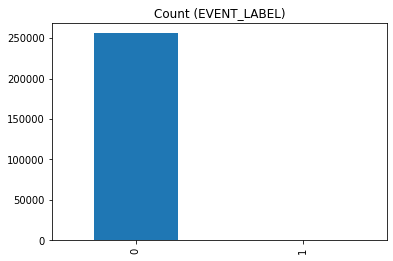

In [61]:
#validating the training dataset
nonfrauds, frauds = data.groupby('EVENT_LABEL').size()
print('Number of frauds: ', frauds)
print('Number of non-frauds: ', nonfrauds)
print('Percentage of fradulent data:', 100.*frauds/(frauds + nonfrauds))

count_class_0, count_class_1 = data.EVENT_LABEL.value_counts()
data.EVENT_LABEL.value_counts().plot(kind='bar', title='Count (EVENT_LABEL)');

Uploading the data for training

In [62]:
csv_buffer = StringIO()
data.to_csv(csv_buffer, index=False)
s3_resource.Object(S3_BUCKET, 'dataset-training.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'AX5P2P5W6K2Y7V2W',
  'HostId': 'dAdIFZFsxxw5ufQqVlMhLaO1zn5bPeuI2w7ua3cqHKYcg8DcZ27gyL3OMuFDaOifAfwszauk39g=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'dAdIFZFsxxw5ufQqVlMhLaO1zn5bPeuI2w7ua3cqHKYcg8DcZ27gyL3OMuFDaOifAfwszauk39g=',
   'x-amz-request-id': 'AX5P2P5W6K2Y7V2W',
   'date': 'Tue, 22 Sep 2020 21:06:38 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"8baed18fc24e97ddcba8e6ff15de1f93"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"8baed18fc24e97ddcba8e6ff15de1f93"',
 'ServerSideEncryption': 'AES256'}

Uploading the data for testing

In [63]:
csv_buffer = StringIO()
test.to_csv(csv_buffer, index=False)

s3_resource.Object(S3_BUCKET, 'dataset-test.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'B6E8DEF11A9A2C22',
  'HostId': 'jqD7xx2/tpv2PnFnhAiHXMRTaF7JDGex1nnP2GYXLFK/O19KkDONmxejes76LkFQtZE9mnbGlZU=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'jqD7xx2/tpv2PnFnhAiHXMRTaF7JDGex1nnP2GYXLFK/O19KkDONmxejes76LkFQtZE9mnbGlZU=',
   'x-amz-request-id': 'B6E8DEF11A9A2C22',
   'date': 'Tue, 22 Sep 2020 21:06:43 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"4338feb9a18c65c7c0c98c68c5c935e6"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"4338feb9a18c65c7c0c98c68c5c935e6"',
 'ServerSideEncryption': 'AES256'}

Once we have the datasets ready we need create the necesary entities for build and deploy the fraud detection model. This can be done within the Amazon Fraud Detector console or through the API as shown in the second jupyter notebook.

Next, we are going to traing and deploy the SageMaker version of the model.

First we copy the data to an in-memory buffer.

In [77]:
buf = io.BytesIO()

sklearn.datasets.dump_svmlight_file(X, y, buf)
buf.seek(0);

Now we upload the data to S3 using boto3.

In [78]:
key = 'sagemaker-dataset-training'
boto3.resource('s3').Bucket(S3_BUCKET).Object(key).upload_fileobj(buf)

s3_train_data = 's3://{}/{}'.format(S3_BUCKET, key)
print('Uploaded training data location: {}'.format(s3_train_data))

output_location = 's3://{}'.format(S3_OUT_BUCKET)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Uploaded training data location: s3://afd-poc-trainingbucket-1i37svk9elcoe/sagemaker-dataset-training
Training artifacts will be uploaded to: s3://afd-poc-outputbucket-1fhn20d7tumgg


We can now train using SageMaker's built-in XGBoost algorithm. To specify the XGBoost algorithm, we use a utility function to obtain its URI. A complete list of built-in algorithms is found here: https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html

In [79]:
container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version='1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


SageMaker abstracts training via Estimators. We can pass the classifier and parameters along with hyperparameters to the estimator, and fit the estimator to the data in S3. An important parameter here is scale_pos_weight which scales the weights of the positive vs. negative class examples. This is crucial to do in an imbalanced dataset like the one we are using here, otherwise the majority class would dominate the learning.

In [80]:
# Because the data set is so highly skewed, we set the scale position weight conservatively,
# as sqrt(num_nonfraud/num_fraud).
# Other recommendations for the scale_pos_weight are setting it to (num_nonfraud/num_fraud).
session = sagemaker.Session()

scale_pos_weight = sqrt(np.count_nonzero(y==0)/np.count_nonzero(y))
hyperparams = {
    "max_depth":5,
    "subsample":0.8,
    "num_round":100,
    "eta":0.2,
    "gamma":4,
    "min_child_weight":6,
    "silent":0,
    "objective":'binary:logistic',
    "eval_metric":'auc',
    "scale_pos_weight": scale_pos_weight
}

clf = sagemaker.estimator.Estimator(container,
                                    get_execution_role(),
                                    hyperparameters=hyperparams,
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path=output_location,
                                    sagemaker_session=session)
clf.fit({'train': s3_train_data})

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-22 21:27:11 Starting - Starting the training job...
2020-09-22 21:27:14 Starting - Launching requested ML instances......
2020-09-22 21:28:42 Starting - Preparing the instances for training............
2020-09-22 21:30:25 Downloading - Downloading input data...
2020-09-22 21:30:46 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[21:31:19] 256326x30 matrix with 7688153 entries loaded from /opt/ml/input/data/train
INFO:root:Single node training.
INFO:root:Train matrix has 256326 rows
[0]#011train-auc:0.94930
[1]#

Now we deploy the estimator to and endpoint.

In [82]:
predictor = clf.deploy(initial_instance_count=1,
                       endpoint_name="fraud-detection-endpoint",
                       instance_type='ml.m4.xlarge', 
                       serializer=csv_serializer,
                       deserializer=None,
                       content_type='text/csv')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!

Once we have trained the model we can use it to make predictions for the test set.

In [83]:
# Because we have a large test set, we call predict on smaller batches
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [84]:
raw_preds = predict(predictor, X_test)

We will use a few measures from the scikit-learn package to evaluate the performance of our model. When dealing with an imbalanced dataset, we need to choose metrics that take into account the frequency of each class in the data.
Two such metrics are the balanced accuracy score, and Cohen's Kappa.

In [201]:
# sagamaker model balanced accuracy for 0.5 threshold
y_preds = np.where(raw_preds > 0.5, 1, 0)
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, y_preds)))

Balanced accuracy = 0.9021211611532022


We can already see that our model performs very well in terms of both metrics, Cohen's Kappa scores above 0.8 are generally very favorable.
Apart from single-value metrics, it's also useful to look at metrics that indicate performance per class. A confusion matrix, and per-class precision, recall and f1-score can also provide more information about the model's performance.

In [202]:
def plot_confusion_matrix(y_true, y_predicted):
    cm  = confusion_matrix(y_true, y_predicted)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()

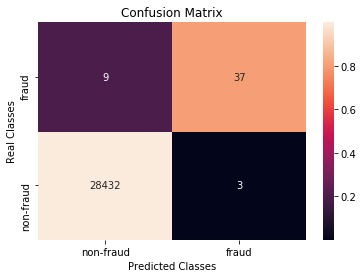

In [203]:
plot_confusion_matrix(y_test, y_preds)

In [204]:
print(classification_report(
    y_test, y_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     28435
       fraud       0.93      0.80      0.86        46

    accuracy                           1.00     28481
   macro avg       0.96      0.90      0.93     28481
weighted avg       1.00      1.00      1.00     28481



Now that we have the sagemaker model, lets build the Amazon Fraud Detector one

In [91]:
# -- This is all you need to fill out. Once complete simply interactively run each code cell. --  
# your_entity_name
ENTITY_TYPE    = "creditcardtrans{0}".format(sufx) 
ENTITY_DESC    = "creditcard transactions: {0}".format(sufx) 
# your_event_type
EVENT_TYPE     = "creditcard{0}".format(sufx) 
EVENT_DESC     = "creditcard card payment events: {0}".format(sufx) 
# your_model_name
MODEL_NAME     = "fraud_detector_model{0}".format(sufx) 
MODEL_DESC     = "model trained on: {0}".format(sufx) 
# your_detector_name
DETECTOR_NAME  = "fraud_detector_endpoint{0}".format(sufx)                        
DETECTOR_DESC  = "detects synthetic fraud events created: {0}".format(sufx) 

In [92]:
# Dataset profiling, just run this code block
def summary_stats(df):
    """ Generate summary statistics for a panda's data frame 
        Args:
            df (DataFrame): panda's dataframe to create summary statistics for.
        Returns:
            DataFrame of summary statistics, training data schema, event variables and event lables 
    """
    df = df.copy()
    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique']).transpose().reset_index().rename(columns={"index":"feature_name"})
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique']/ rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner').round(4)
    df_stats['nunique'] = df_stats['nunique'].astype('int64')
    df_stats['count'] = df_stats['count'].astype('int64')
    
    # -- variable type mapper --  
    df_stats['feature_type'] = "UNKOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"].str.contains("ipaddress|ip_address|ipcli"), 'feature_type'] = "IP_ADDRESS"
    df_stats.loc[df_stats["feature_name"].str.contains("email|email_address|emailaddr"), 'feature_type'] = "EMAIL_ADDRESS"
    df_stats.loc[df_stats["feature_name"].str.contains("canal|channel"), 'feature_type'] = "USERAGENT"
    df_stats.loc[df_stats["feature_name"].str.contains("monto|amount"), 'feature_type'] = "PRICE"
    df_stats.loc[df_stats["feature_name"].str.contains("nomdes|name"), 'feature_type'] = "BILLING_NAME"
    df_stats.loc[df_stats["feature_name"] == "EVENT_LABEL", 'feature_type'] = "TARGET"
    df_stats.loc[df_stats["feature_name"] == "EVENT_TIMESTAMP", 'feature_type'] = "EVENT_TIMESTAMP"
    
    # -- variable warnings -- 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[(df_stats["nunique"] != 2) & (df_stats["feature_name"] == "EVENT_LABEL"),'feature_warning' ] = "LABEL WARNING, NON-BINARY EVENT LABEL"
    df_stats.loc[(df_stats["nunique_pct"] > 0.97) & (df_stats['feature_type'] == "CATEGORY") ,'feature_warning' ] = "EXCLUDE, GT 97% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
   
    # -- target check -- 
    exclude_fields  = df_stats.loc[(df_stats['feature_warning'] != 'NO WARNING')]['feature_name'].to_list()
    event_variables = df_stats.loc[(~df_stats['feature_name'].isin(['EVENT_LABEL', 'EVENT_TIMESTAMP']))]['feature_name'].to_list()
    event_labels    = df["EVENT_LABEL"].unique().tolist()
    
    trainingDataSchema = {
        'modelVariables' : df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list(),
        'labelSchema'    : {
            'labelMapper' : {
                'FRAUD' : [str(df["EVENT_LABEL"].value_counts().idxmin())],
                'LEGIT' : [str(df["EVENT_LABEL"].value_counts().idxmax())]
            }
        }
    }
    
    
    model_variables = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list()
   
    
    # -- label schema -- 
    label_map = {
        'FRAUD' : [df["EVENT_LABEL"].value_counts().idxmin()],
        'LEGIT' : [df["EVENT_LABEL"].value_counts().idxmax()]
    }
    
    
    print("--- summary stats ---")
    print(df_stats)
    print("\n")
    print("--- event variables ---")
    print(event_variables)
    print("\n")
    print("--- event labels ---")
    print(event_labels)
    print("\n")
    print("--- training data schema ---")
    print(trainingDataSchema)
    print("\n")
    
    return df_stats, trainingDataSchema, event_variables, event_labels

# -- connect to S3, snag file, and convert to a panda's dataframe --
#s3   = boto3.resource('s3')
#obj  = s3.Object(S3_BUCKET, S3_FILE)
#body = obj.get()['Body']
#df   = pd.read_csv(body)

# -- call profiling function -- 
df_stats, trainingDataSchema, eventVariables, eventLabels = summary_stats(data)

--- summary stats ---
       feature_name    dtype   count  nunique  null  not_null  null_pct  nunique_pct     feature_type feature_warning
0              time  float64  256326   119735     0    256326       0.0       0.4671          NUMERIC      NO WARNING
1                va  float64  256326   248553     0    256326       0.0       0.9697          NUMERIC      NO WARNING
2                vb  float64  256326   248553     0    256326       0.0       0.9697          NUMERIC      NO WARNING
3                vc  float64  256326   248553     0    256326       0.0       0.9697          NUMERIC      NO WARNING
4                vd  float64  256326   248553     0    256326       0.0       0.9697          NUMERIC      NO WARNING
5                ve  float64  256326   248553     0    256326       0.0       0.9697          NUMERIC      NO WARNING
6                vf  float64  256326   248553     0    256326       0.0       0.9697          NUMERIC      NO WARNING
7                vg  float64  2563

In [93]:
# Variable creation just run this code block
def create_label(df, FRAUD_LABEL):
    """
    Returns a dictionary for the model labelSchema, by identifying the rare event as fraud / and common as not-fraud 
    
    Arguments:
    df          -- input dataframe 
    FRAUD_LABEL -- the name of the field that contains fraud label  
    
    Returns:
    labelSchema -- a dictionary containing labelKey & labelMapper 
    """
    label_summary = df[FRAUD_LABEL].value_counts()
    labelSchema = {'labelKey': FRAUD_LABEL,
                   "labelMapper" : { "FRAUD": [str(label_summary.idxmin())], 
                                     "LEGIT": [str(label_summary.idxmax())]}
                  }
    afd_resource.put_label(
                name = str(label_summary.idxmin()),
                description = 'FRAUD')
    
    afd_resource.put_label(
                name = str(label_summary.idxmax()),
                description = 'LEGIT')
    
    return labelSchema
    
# -- function to create all your variables --- 
def create_variables(df_stats, MODEL_NAME):
    """
    Returns a variable list of model input variables, checks to see if variable exists,
    and, if not, then it adds the variable to Fraud Detector 
    
    Arguments: 
    enrichment_features  -- dictionary of optional features, mapped to specific variable types enriched (CARD_BIN, USERAGENT)
    numeric_features     -- optional list of numeric field names 
    categorical_features -- optional list of categorical features 
    
    Returns:
    variable_list -- a list of variable dictionaries 
    
    """
    enrichment_features = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'USERAGENT', 'BILLING_NAME', 'PRICE']))]['feature_name'].to_dict()
    enrichment_type = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'USERAGENT', 'BILLING_NAME', 'PRICE']))]['feature_type'].to_dict()
    numeric_features = df_stats.loc[(df_stats['feature_type'].isin(['NUMERIC']))]['feature_name'].to_dict()
    categorical_features = df_stats.loc[(df_stats['feature_type'].isin(['CATEGORY']))]['feature_name'].to_dict()
    
    variable_list = []
    # -- first do the enrichment features
    for feature in enrichment_features.keys(): 
        variable_list.append( {'name' : enrichment_features[feature]+""})
        try:
            varname = enrichment_features[feature]+""
            afd_resource.get_variables(name=varname)
        except:
            print("Creating variable: {0}".format(enrichment_features[feature]))
            if enrichment_type[feature] == "PRICE":
                resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'FLOAT',
                    dataSource ='EVENT',
                    defaultValue = '0', 
                    description = enrichment_features[feature],
                    variableType = enrichment_type[feature] )
            else:
                resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = enrichment_features[feature],
                    variableType = enrichment_type[feature] )
                
               
    # -- check and update the numeric features 
    for feature in numeric_features: 
        variable_list.append( {'name' : numeric_features[feature]+""})
        try:
            varname = numeric_features[feature]+""
            afd_resource.get_variables(name=varname)
        except:
            print("Creating variable: {0}".format(numeric_features[feature]))
            resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'FLOAT',
                    dataSource ='EVENT',
                    defaultValue = '0.0', 
                    description = numeric_features[feature],
                    variableType = 'NUMERIC' )
             
    # -- check and update the categorical features 
    for feature in categorical_features: 
        variable_list.append( {'name' : categorical_features[feature]+""})
        try:
            varname = categorical_features[feature]+""
            afd_resource.get_variables(name=varname)
        except:
            print("Creating variable: {0}".format(categorical_features[feature]))
            resp = afd_resource.create_variable(
                    name = varname,
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = categorical_features[feature],
                    variableType = 'CATEGORICAL' )
    
    # -- create a model score feature  
    model_feature = "{0}_insightscore".format(MODEL_NAME)  
    # variable_list.append( {'name' : model_feature})
    try:
        afd_resource.get_variables(name=model_feature)
    except:
        print("Creating variable: {0}".format(model_feature))
        resp = afd_resource.create_variable(
                name = model_feature,
                dataType = 'FLOAT',
                dataSource ='MODEL_SCORE',
                defaultValue = '0.0', 
                description = model_feature,
                variableType = 'NUMERIC' )
    
    return variable_list


model_variables = create_variables(df_stats, MODEL_NAME)
print("\n --- model variable dict --")
print(model_variables)


model_label = create_label(data, "EVENT_LABEL")
print("\n --- model label schema dict --")
print(model_label)

Creating variable: time
Creating variable: fraud_detector_model20200922_insightscore

 --- model variable dict --
[{'name': 'amount'}, {'name': 'time'}, {'name': 'va'}, {'name': 'vb'}, {'name': 'vc'}, {'name': 'vd'}, {'name': 've'}, {'name': 'vf'}, {'name': 'vg'}, {'name': 'vh'}, {'name': 'vi'}, {'name': 'vj'}, {'name': 'vk'}, {'name': 'vl'}, {'name': 'vm'}, {'name': 'vn'}, {'name': 'vo'}, {'name': 'vp'}, {'name': 'vq'}, {'name': 'vr'}, {'name': 'vs'}, {'name': 'vt'}, {'name': 'vu'}, {'name': 'vv'}, {'name': 'vw'}, {'name': 'vx'}, {'name': 'vy'}, {'name': 'vz'}, {'name': 'vaa'}, {'name': 'vab'}]

 --- model label schema dict --
{'labelKey': 'EVENT_LABEL', 'labelMapper': {'FRAUD': ['1'], 'LEGIT': ['0']}}


In [94]:
#Amazon Fraud Detector expect the labels to be strings.
eventLabels = list(map(str, eventLabels))
print(eventLabels)

['0', '1']


In [95]:
# Creating entity and event types just run this code block ---
response = afd_resource.put_entity_type(
    name        = ENTITY_TYPE,
    description = ENTITY_DESC
)
print("-- create entity --")
print(response)

response = afd_resource.put_event_type (
    name           = EVENT_TYPE,
    eventVariables = eventVariables,
    labels         = eventLabels,
    entityTypes    = [ENTITY_TYPE])
print("-- create event type --")
print(response)

-- create entity --
{'ResponseMetadata': {'RequestId': '88e9d45f-2c8b-4a90-b58c-8a6dcea3bc40', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 22 Sep 2020 21:48:52 GMT', 'x-amzn-requestid': '88e9d45f-2c8b-4a90-b58c-8a6dcea3bc40', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}
-- create event type --
{'ResponseMetadata': {'RequestId': 'd48b2c1c-34a2-4c97-bc7d-52c0e192f729', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 22 Sep 2020 21:48:53 GMT', 'x-amzn-requestid': 'd48b2c1c-34a2-4c97-bc7d-52c0e192f729', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [96]:
# -- create our model --
response = afd_resource.create_model(
   description   = MODEL_DESC,
   eventTypeName = EVENT_TYPE,
   modelId       = MODEL_NAME,
   modelType   = 'ONLINE_FRAUD_INSIGHTS')
print("-- initalize model --")
print(response)

-- initalize model --
{'ResponseMetadata': {'RequestId': '2c15f806-c600-4217-b400-8332dda66a47', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 22 Sep 2020 21:48:56 GMT', 'x-amzn-requestid': '2c15f806-c600-4217-b400-8332dda66a47', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [97]:
# -- initializes the model, it's now ready to train -- 
S3_FILE        = "dataset-training.csv"
S3_FILE_LOC    = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)

response = afd_resource.create_model_version(
    modelId     = MODEL_NAME,
    modelType   = 'ONLINE_FRAUD_INSIGHTS',
    trainingDataSource = 'EXTERNAL_EVENTS',
    trainingDataSchema = trainingDataSchema,
    externalEventsDetail = {
        'dataLocation'     : S3_FILE_LOC,
        'dataAccessRoleArn': ARN_ROLE
    }
)
print("-- model training --")
print(response)

-- model training --
{'modelId': 'fraud_detector_model20200922', 'modelType': 'ONLINE_FRAUD_INSIGHTS', 'modelVersionNumber': '1.0', 'status': 'TRAINING_IN_PROGRESS', 'ResponseMetadata': {'RequestId': 'e88dc617-42fe-4971-9509-ee6d1fbdf6f8', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 22 Sep 2020 21:49:02 GMT', 'x-amzn-requestid': 'e88dc617-42fe-4971-9509-ee6d1fbdf6f8', 'content-length': '137', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [98]:
# -- model training takes time, we'll loop until it's complete  -- 
print("-- wait for model training to complete --")
stime = time.time()
while True:
    clear_output(wait=True)
    response = afd_resource.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] == 'TRAINING_IN_PROGRESS':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    if response['status'] != 'TRAINING_IN_PROGRESS':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()

# -- summarize -- 
print("\n --- model training complete  --")
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

Model status : TRAINING_COMPLETE

 --- model training complete  --
Elapsed time : 3134.791792869568 seconds 

{'modelId': 'fraud_detector_model20200922', 'modelType': 'ONLINE_FRAUD_INSIGHTS', 'modelVersionNumber': '1.0', 'trainingDataSource': 'EXTERNAL_EVENTS', 'trainingDataSchema': {'modelVariables': ['time', 'va', 'vb', 'vc', 'vd', 've', 'vf', 'vg', 'vh', 'vi', 'vj', 'vk', 'vl', 'vm', 'vn', 'vo', 'vp', 'vq', 'vr', 'vs', 'vt', 'vu', 'vv', 'vw', 'vx', 'vy', 'vz', 'vaa', 'vab'], 'labelSchema': {'labelMapper': {'FRAUD': ['1'], 'LEGIT': ['0']}}}, 'externalEventsDetail': {'dataLocation': 's3://afd-poc-trainingbucket-1i37svk9elcoe/dataset-training.csv', 'dataAccessRoleArn': 'arn:aws:iam::387461613214:role/afd-poc-NotebookInstanceExecutionRole-1FNQ41S8H2G68'}, 'status': 'TRAINING_COMPLETE', 'arn': 'arn:aws:frauddetector:us-west-2:387461613214:model-version/ONLINE_FRAUD_INSIGHTS/fraud_detector_model20200922/1.0', 'ResponseMetadata': {'RequestId': '7386e6d4-a8b0-4033-b965-899cd5814a26', 'HTTPS

In [99]:
# activating the model
response = afd_resource.update_model_version_status (
    modelId = MODEL_NAME,
    modelType = 'ONLINE_FRAUD_INSIGHTS',
    modelVersionNumber = '1.0',
    status = 'ACTIVE'
)
print("-- activating model --")
print(response)

#-- wait until model is active 
print("--- waiting until model status is active ")
stime = time.time()
while True:
    clear_output(wait=True)
    response = afd_resource.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] != 'ACTIVE':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'ACTIVE':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

Model status : ACTIVE
Elapsed time : 602.6856355667114 seconds 

{'modelId': 'fraud_detector_model20200922', 'modelType': 'ONLINE_FRAUD_INSIGHTS', 'modelVersionNumber': '1.0', 'trainingDataSource': 'EXTERNAL_EVENTS', 'trainingDataSchema': {'modelVariables': ['time', 'va', 'vb', 'vc', 'vd', 've', 'vf', 'vg', 'vh', 'vi', 'vj', 'vk', 'vl', 'vm', 'vn', 'vo', 'vp', 'vq', 'vr', 'vs', 'vt', 'vu', 'vv', 'vw', 'vx', 'vy', 'vz', 'vaa', 'vab'], 'labelSchema': {'labelMapper': {'FRAUD': ['1'], 'LEGIT': ['0']}}}, 'externalEventsDetail': {'dataLocation': 's3://afd-poc-trainingbucket-1i37svk9elcoe/dataset-training.csv', 'dataAccessRoleArn': 'arn:aws:iam::387461613214:role/afd-poc-NotebookInstanceExecutionRole-1FNQ41S8H2G68'}, 'status': 'ACTIVE', 'arn': 'arn:aws:frauddetector:us-west-2:387461613214:model-version/ONLINE_FRAUD_INSIGHTS/fraud_detector_model20200922/1.0', 'ResponseMetadata': {'RequestId': 'bca2079c-03d0-42f1-9863-7cd0c71fc4dc', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'applic

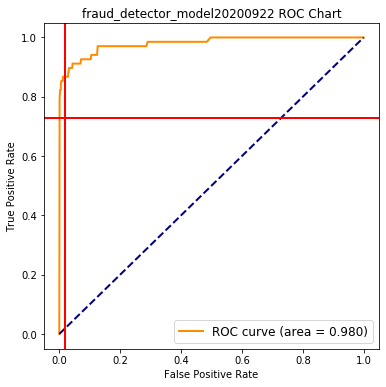

In [185]:
# -- model performance summary -- 
auc = afd_resource.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc']


df_model = pd.DataFrame(afd_resource.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['metricDataPoints'])


plt.figure(figsize=(6,6))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( MODEL_NAME + ' ROC Chart')
plt.legend(loc="lower right",fontsize=12)
plt.axvline(x = 0.02 ,linewidth=2, color='r')
plt.axhline(y = 0.73 ,linewidth=2, color='r')
plt.show()

In [101]:
# -- initialize your detector -- 
response = afd_resource.put_detector(detectorId  = DETECTOR_NAME, 
                               description = DETECTOR_DESC, 
                               eventTypeName = EVENT_TYPE )

print(response)

{'ResponseMetadata': {'RequestId': '4c1eb5b8-0bb0-4ac0-abf0-49d55c3861c6', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 22 Sep 2020 22:55:06 GMT', 'x-amzn-requestid': '4c1eb5b8-0bb0-4ac0-abf0-49d55c3861c6', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [102]:
# -- make rules -- 
model_stat = df_model.round(decimals=2)  

m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()] 

def make_rule(x):
    rule = ""
    if x['fpr'] <= 0.05: 
        rule = "${0}_insightscore > {1}".format(MODEL_NAME,x['threshold'])
    if x['fpr'] == 0.06:
        rule = "${0}_insightscore <= {1}".format(MODEL_NAME,x['threshold_prev'])
    return rule
    
m["threshold_prev"] = m['threshold'].shift(1)
m['rule'] = m.apply(lambda x: make_rule(x), axis=1)

m['outcome'] = "approve"
m.loc[m['fpr'] <= 0.03, "outcome"] = "fraud"
m.loc[(m['fpr'] > 0.03) & (m['fpr'] <= 0.05), "outcome"] = "investigate"

print (" --- score thresholds 1% to 6% --- ")
print(m[["fpr", "tpr", "threshold", "rule", "outcome"]].loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.06)].reset_index(drop=True))

 --- score thresholds 1% to 6% --- 
    fpr   tpr  threshold                                               rule      outcome
0  0.01  0.85      970.0  $fraud_detector_model20200922_insightscore > 9...        fraud
1  0.02  0.87      925.0  $fraud_detector_model20200922_insightscore > 9...        fraud
2  0.03  0.87      880.0  $fraud_detector_model20200922_insightscore > 8...        fraud
3  0.04  0.90      835.0  $fraud_detector_model20200922_insightscore > 8...  investigate
4  0.05  0.91      790.0  $fraud_detector_model20200922_insightscore > 7...  investigate
5  0.06  0.91      755.0  $fraud_detector_model20200922_insightscore <= ...      approve


In [103]:
# -- create outcomes -- 
def create_outcomes(outcomes):
    """ create Fraud Detector Outcomes 
    
    """   
    for outcome in outcomes:
        print("creating outcome variable: {0} ".format(outcome))
        response = afd_resource.put_outcome(
                          name=outcome,
                          description=outcome)

# -- get distinct outcomes 
outcomes = m["outcome"].unique().tolist()

create_outcomes(outcomes)

creating outcome variable: fraud 
creating outcome variable: investigate 
creating outcome variable: approve 


In [104]:
# creating te rules with the desired outcomes associated with our detector
rule_set = m[(m["fpr"] > 0.0) & (m["fpr"] <= 0.06)][["outcome", "rule"]].to_dict('records')
rule_list = []
for i, rule in enumerate(rule_set):
    ruleId = "rule{0}_{1}".format(i, MODEL_NAME)
    rule_list.append({"ruleId": ruleId, 
                      "ruleVersion" : '1',
                      "detectorId"  : DETECTOR_NAME
        
    })
    print("creating rule: {0}: IF {1} THEN {2}".format(ruleId, rule["rule"], rule['outcome']))
    try:
        response = afd_resource.create_rule(
            ruleId = ruleId,
            detectorId = DETECTOR_NAME,
            expression = rule['rule'],
            language = 'DETECTORPL',
            outcomes = [rule['outcome']]
            )
    except:
        print("this rule already exists in this detector")
rule_list

creating rule: rule0_fraud_detector_model20200922: IF $fraud_detector_model20200922_insightscore > 970.0 THEN fraud
creating rule: rule1_fraud_detector_model20200922: IF $fraud_detector_model20200922_insightscore > 925.0 THEN fraud
creating rule: rule2_fraud_detector_model20200922: IF $fraud_detector_model20200922_insightscore > 880.0 THEN fraud
creating rule: rule3_fraud_detector_model20200922: IF $fraud_detector_model20200922_insightscore > 835.0 THEN investigate
creating rule: rule4_fraud_detector_model20200922: IF $fraud_detector_model20200922_insightscore > 790.0 THEN investigate
creating rule: rule5_fraud_detector_model20200922: IF $fraud_detector_model20200922_insightscore <= 790.0 THEN approve


[{'ruleId': 'rule0_fraud_detector_model20200922',
  'ruleVersion': '1',
  'detectorId': 'fraud_detector_endpoint20200922'},
 {'ruleId': 'rule1_fraud_detector_model20200922',
  'ruleVersion': '1',
  'detectorId': 'fraud_detector_endpoint20200922'},
 {'ruleId': 'rule2_fraud_detector_model20200922',
  'ruleVersion': '1',
  'detectorId': 'fraud_detector_endpoint20200922'},
 {'ruleId': 'rule3_fraud_detector_model20200922',
  'ruleVersion': '1',
  'detectorId': 'fraud_detector_endpoint20200922'},
 {'ruleId': 'rule4_fraud_detector_model20200922',
  'ruleVersion': '1',
  'detectorId': 'fraud_detector_endpoint20200922'},
 {'ruleId': 'rule5_fraud_detector_model20200922',
  'ruleVersion': '1',
  'detectorId': 'fraud_detector_endpoint20200922'}]

In [105]:
# creating the detector
afd_resource.create_detector_version(
    detectorId = DETECTOR_NAME,
    rules = rule_list,
    modelVersions = [{"modelId":MODEL_NAME, 
                      "modelType" : "ONLINE_FRAUD_INSIGHTS",
                      "modelVersionNumber" : "1.0"}],
    ruleExecutionMode = 'FIRST_MATCHED'
    )

print("\n -- detector created -- ")
print(response) 


 -- detector created -- 
{'rule': {'detectorId': 'fraud_detector_endpoint20200922', 'ruleId': 'rule5_fraud_detector_model20200922', 'ruleVersion': '1'}, 'ResponseMetadata': {'RequestId': 'ceb37fe4-61df-4797-b198-341bf37b8a7d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 22 Sep 2020 22:55:26 GMT', 'x-amzn-requestid': 'ceb37fe4-61df-4797-b198-341bf37b8a7d', 'content-length': '121', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [106]:
# activating the detector
response = afd_resource.update_detector_version_status(
    detectorId= DETECTOR_NAME,
    detectorVersionId='1',
    status='ACTIVE'
)
print("\n -- detector activated -- ")
print(response)


 -- detector activated -- 
{'ResponseMetadata': {'RequestId': '12c43795-ac18-42d6-8d07-22f49ca7014d', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 22 Sep 2020 22:55:37 GMT', 'x-amzn-requestid': '12c43795-ac18-42d6-8d07-22f49ca7014d', 'content-length': '2', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


Testing our model endpoint

In [107]:
S3_FILE        = "dataset-test.csv"
S3_FILE_LOC    = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)

s3_resource.Bucket(S3_BUCKET).download_file(S3_FILE, 'dataset-test.csv')

In [108]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

test = pd.read_csv('dataset-test.csv', delimiter=',')
test.head(10)

,time,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount
0,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,5.299236,-10.834006,1.671120,-9.373859,0.360806,-9.899247,-19.236292,-8.398552,3.101735,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19
1,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,-0.087670,0.979427,0.076883,-0.217884,-0.136830,-2.142892,0.126956,1.752662,0.432546,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12
2,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,0.543827,0.112453,1.075384,-0.245772,0.180483,1.769860,-0.533172,-0.533300,1.192245,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00
3,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,-1.328335,0.223621,1.132627,-0.550875,0.616568,0.497974,0.502195,0.981343,0.101264,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50
4,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,0.942162,0.850038,-0.616166,0.592634,-0.603845,0.091077,-0.471867,-0.333816,0.404711,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89
5,67878.0,-0.641330,-0.057304,1.489998,-1.688131,-1.151043,0.259996,-1.391069,-2.334075,1.168644,-2.084080,0.480381,0.473738,-2.192276,0.773942,0.294484,0.406074,-0.541855,1.031450,0.017076,0.618411,-1.231634,0.257164,-0.371953,-0.038566,1.397514,-0.665947,0.031003,0.180357,100.00
6,159763.0,2.023952,-0.120140,-1.086918,0.423019,-0.142901,-1.127752,0.178493,-0.303234,0.564509,0.062831,-0.720047,0.366835,-0.110857,0.319094,0.108359,-0.153633,-0.221312,-0.934141,0.070553,-0.210864,-0.276175,-0.697708,0.335631,-0.017196,-0.324904,0.200023,-0.071566,-0.058224,16.99
7,139631.0,-0.688944,1.292153,-0.564281,-1.457526,2.258333,-0.323270,1.678984,-0.104128,-1.285351,-1.303435,0.282728,-0.402525,-0.548687,-0.504283,-0.685339,0.714828,-0.092674,0.798953,-0.150085,-0.037150,-0.006880,-0.171568,-0.720019,-0.419435,1.211991,0.670916,-0.103986,0.030084,8.95
8,133944.0,2.119362,0.142639,-2.373337,0.541949,0.608419,-1.775564,0.955775,-0.599383,0.010420,0.295305,-0.936569,-0.452478,-1.340798,1.077459,-0.099584,-0.815072,0.018481,-0.639446,-0.065427,-0.323573,0.264264,0.898266,-0.168063,0.059311,0.626949,0.729035,-0.129120,-0.094713,10.00
9,58769.0,-5.584256,-4.732413,-0.448452,-0.121442,-0.707412,-0.114376,-1.554628,1.402126,-0.031693,-0.942358,-2.439501,-0.552312,-0.295588,-0.250246,-1.197732,1.549553,0.933237,-1.237689,0.416832,-1.046900,0.041651,0.621789,0.223467,-0.770137,0.621182,-0.028738,0.505194,-1.898323,101.49


Cleaning the test dataset from training columns and defining the start datetime.

In [109]:
record_count = 500
model_variables = [column for column in test.columns if column not in  ['EVENT_LABEL', 'EVENT_TIMESTAMP']]
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%Y-%m-%dT%H:%M:%SZ")
print(' '.join(model_variables))

time va vb vc vd ve vf vg vh vi vj vk vl vm vn vo vp vq vr vs vt vu vv vw vx vy vz vaa vab amount


In [110]:
import uuid

# test the endpoint with a single prediction.
eventId = uuid.uuid1()
testrecord = test[model_variables].head(15).astype(str).to_dict(orient='records')[6]
pred = afd_resource.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  testrecord)
print(pred)

{'modelScores': [{'modelVersion': {'modelId': 'fraud_detector_model20200922', 'modelType': 'ONLINE_FRAUD_INSIGHTS', 'modelVersionNumber': '1.0'}, 'scores': {'fraud_detector_model20200922_insightscore': 8.0}}], 'ruleResults': [{'ruleId': 'rule5_fraud_detector_model20200922', 'outcomes': ['approve']}], 'ResponseMetadata': {'RequestId': 'd85b48b5-4ed8-495f-a7ee-e545092a9021', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Tue, 22 Sep 2020 22:56:18 GMT', 'x-amzn-requestid': 'd85b48b5-4ed8-495f-a7ee-e545092a9021', 'content-length': '286', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [122]:
test.count()
y_test

(28481,)

The next block will use some parallelization to run several test against the fraud detector endpoint.

In [ ]:
import dask 
import time
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% }</style>"))

start = time.time()

@dask.delayed
def _predict(record):
    eventId = uuid.uuid1()
    try:
        pred = afd_resource.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  record) 
        
        record["score"]   = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
        if len(pred['ruleResults']) > 0:
            record["outcomes"]= pred['ruleResults'][0]['outcomes']
        else:
            record["outcomes"]= 'approve'
        return record
    
    except:
        pred  = afd_resource.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  record) 
        record["score"]   = "-999"
        record["outcomes"]= "error"
        return record

In [ ]:
# dask approach, if you want to run the entire test dataset(28481) preffer the loop approach on the next cell
predict_data  = test[model_variables].head(400).astype(str).to_dict(orient='records')
predict_score = []

i=0
for record in predict_data:
    clear_output(wait=True)
    rec = dask.delayed(_predict)(record)
    predict_score.append(rec)
    i += 1
    print("current progress: ", round((i/record_count)*100,2), "%" )
    
predict_recs = dask.compute(*predict_score)

# Calculate time taken and print results
time_taken = time.time() - start
tps = len(predict_recs) / time_taken

print ('Process took %0.2f seconds' %time_taken)
print ('Scored %d records' %len(predict_recs))

In [124]:
# loop approach, slower but doesnt freeze the browser, go grab a coffe :)
predict_data  = test[model_variables].head(28481).astype(str).to_dict(orient='records')
predict_score = []
start = time.time()

for record in predict_data:
    eventId = uuid.uuid1()
    pred = afd_resource.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = timestampStr, 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=  record)
    record["score"] = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
    


# Calculate time taken and print results
time_taken = time.time() - start
tps = len(predict_recs) / time_taken

print ('Process took %0.2f seconds' %time_taken)
print ('Scored %d records' %len(predict_data))

Process took 4600.17 seconds
Scored 28481 records


In [184]:
p_data = [d['score'] for d in predict_data]

In [205]:
# fraud detector model balanced accuracy for 0.9 threshold
afd_preds = np.where(np.array(p_data) > 950, 1, 0)
print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, afd_preds)))

Balanced accuracy = 0.949470569796867


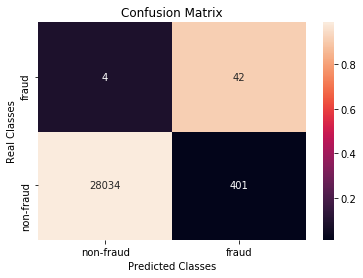

In [183]:
plot_confusion_matrix(y_test, afd_preds)

In [206]:
print(classification_report(
    y_test, afd_preds, target_names=['non-fraud', 'fraud']))

              precision    recall  f1-score   support

   non-fraud       1.00      0.99      0.99     28435
       fraud       0.09      0.91      0.17        46

    accuracy                           0.99     28481
   macro avg       0.55      0.95      0.58     28481
weighted avg       1.00      0.99      0.99     28481



In [112]:
# lets take a look to the predicted frauds
predictions = pd.DataFrame.from_dict(predict_recs, orient='columns')
predictions.loc[predictions['score'].astype('float32') > 900]

,time,va,vb,vc,vd,ve,vf,vg,vh,vi,vj,vk,vl,vm,vn,vo,vp,vq,vr,vs,vt,vu,vv,vw,vx,vy,vz,vaa,vab,amount,score,outcomes
0,41505.0,-16.5265065691231,8.58497179585822,-18.649853185194498,9.50559351508723,-13.793818527095699,-2.8324042993974703,-16.701694296045,7.517343903709871,-8.50705863675898,-14.110184441545696,5.29923634963938,-10.8340064814734,1.67112025332681,-9.37385858364976,0.36080564163161705,-9.899246540806661,-19.2362923697613,-8.39855199494575,3.10173536885404,-1.51492343527852,1.19073869481428,-1.1276700090206102,-2.3585787697881,0.6734613289872371,-1.4136996745881998,-0.46276236139933,-2.01857524875161,-1.04280416970881,364.19,1000.0,[fraud]
16,52913.0,0.676854829386595,1.58702920998622,-1.50814698254807,1.44381484435084,1.31678997910859,-1.1603421410518702,1.1490491098159,-0.4193931328245341,-0.0905654487115674,-0.323058484892761,2.967920897973221,-0.155026280352087,-0.7177661091303009,-3.70927517991521,0.731050307180359,0.51012502005825,2.7302621301168104,1.46374586218951,-0.578405585881194,0.31792704392540505,-0.191418401886823,0.101450781492372,0.05829839657805901,-0.135311156556857,-0.6044061673895129,-0.4527632157702071,0.0464301769729269,-0.3836415178705061,0.89,977.0,[fraud]
19,55575.0,-3.41942263819263,-1.13007559809015,1.60708637375377,2.2299789220985096,2.64408903133496,-0.7935377223504201,1.08824220975816,-1.00840988415033,-0.933315168258216,1.92198175926539,1.9544453994250897,0.388839766922148,0.30147367767299,-0.427868493466856,-0.0292266721907548,-0.0750638320495107,-0.7991270792650841,-0.629796480633153,-0.469016593690311,-1.44533223472583,-0.479674205429058,0.524022264453329,0.093685026163671,0.30523015264387393,0.6539626403904271,0.0228521071220258,-0.955552398442486,-0.0856295445716383,22.7,953.0,[fraud]
32,141655.0,-29.942972270707894,-25.8317821051362,-16.2275119291273,6.690679169572508,-20.7878458115363,13.0856943709389,17.2566228959585,-9.16174621113856,5.00304130464362,-2.4314663912742,1.7599893933563102,1.86143271752851,3.05338368623288,-1.4096397429751502,3.68027152852471,4.53127503027372,0.22001123266623696,-1.60453617589942,3.14031061569242,-21.3871219290332,-2.49469918146669,-0.660297208514391,-8.53781580651041,0.40080447201294,-0.643022787031134,0.4969028458312689,6.26770908866261,-2.7650700017587595,3502.11,962.0,[fraud]
51,56803.0,1.17360912432855,0.511603445630379,-0.5204514757086011,1.12262620608436,0.35886736932159297,-0.29596043353185303,0.0250046387752933,0.14444171501870098,-0.110183833896483,-0.513358438415108,1.50090553458987,-0.228726450784267,-1.5703348271985802,-0.839677563070961,0.8255113303861942,0.6647743241018189,0.886274830361083,0.925736187467082,-0.5606318507221589,-0.20184199976003606,-0.0268349064777576,-0.0755364811334122,-0.129545704955994,-0.4816867297130711,0.582500674589865,-0.289875901401972,0.0379128239034746,0.0374365751819376,1.0,958.0,[fraud]
59,94330.0,-0.159188253451539,1.6364222543563205,1.54599038025481,4.55479940392864,0.972500161314345,0.135619469003896,0.890709635187871,-0.308928981901544,-0.750671002033175,1.48808516225536,0.0189227146632523,-3.51495112016203,1.37852083915781,1.7509347239023998,0.0364873683299348,-0.332543453736555,0.8312407987466272,0.0272426739399668,1.11755527782445,0.374095700292396,-0.4149084993816161,-0.7253325636219929,0.0198138142745913,-0.0804172850283939,-0.5666438490691871,0.0294988448472911,0.206860492083663,0.00306000773670604,12.74,965.0,[fraud]
177,58954.0,1.23804261799844,0.77053043333537,-0.331997523908519,1.34546451219451,0.139816295211697,-1.22967596595336,0.354259165638368,-0.280804576159513,-0.184996149214632,-0.699812889267707,0.230655066658352,0.21477524724131605,0.561439138721415,-1.4597942610637098,1.0212476623650102,0.567113655972287,0.859052402876907,0.516214961212954,-0.629783953300129,-0.0582422755483618,-0.0605703154557262,-0.0710964980063678,-0.131000023986718,0.269144247106671,0.7120999799201929,-0.32948917861264804,0.039308026136455,0.0588378743714698,1.0,947.0,[fraud]
253,878.0,-2.5121924071651502,0.

In [113]:
# save the results to a csv file and upload it to the output s3 bucket
csv_buffer = StringIO()
predictions.to_csv(csv_buffer, index=False)
s3_resource.Object(S3_BUCKET, MODEL_NAME + "precictions{}.csv".format(sufx)).put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '5B6ED35CCB4FB643',
  'HostId': 'lfEj4Wi46OeQJbr7wiYy4Vh2xqAZdNFjHDXWIx449ZKcXRkZIb+RNiqI5eeyQ3fKi+Gv/0YZTtI=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'lfEj4Wi46OeQJbr7wiYy4Vh2xqAZdNFjHDXWIx449ZKcXRkZIb+RNiqI5eeyQ3fKi+Gv/0YZTtI=',
   'x-amz-request-id': '5B6ED35CCB4FB643',
   'date': 'Tue, 22 Sep 2020 22:57:06 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"a349bb5bdc090d7f8ce04f7816ac60d5"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"a349bb5bdc090d7f8ce04f7816ac60d5"',
 'ServerSideEncryption': 'AES256'}

Finish